Run the first two cells before running anything else

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.optimize import curve_fit

import rasterio
from scipy.ndimage import gaussian_filter

In [17]:
def get_cumulative_area(df, total_area, minimum = 0):
    df = df[df.diameter > minimum]
    # Sort the dataframe by diameter in descending order
    df_sorted = df.sort_values(by=['diameter'], ascending=False)

    # Calculate the cumulative area
    df_sorted['cumulative_area'] = df_sorted['boulder_area'].cumsum()

    # Extract the diameters and cumulative areas into separate arrays
    diameters = df_sorted['diameter'].to_numpy()
    cumulative_areas = df_sorted['cumulative_area'].to_numpy()
    cumulative_areas /= total_area
    
    return diameters, cumulative_areas

def rock_abundance_function(D, k, q):
    return k * np.exp(-q * D)

# Figure 1 (Boulder Maps & BoulderNet Rock Abundance vs Diameter)

Figures 1 a-c were made with QGIS. 

(a) uses APOLLO17_ORTHOMOSAIC_50CM.TIFF as background and yolo_boulders_with_RA_and_tileID.shp 

(b) uses DivinerRockAbundanceMap.tif 

(c) uses YoloBoulderNetRockAbundanceMap.tif

# Figure 2 (Overall Rock Abundance Model Fit)

In [79]:
bouldersGDFYolo = pd.read_csv('Data/yolo_boulders_with_RA_and_tileID.csv')
bouldersGDFYolo['tile_area'] = bouldersGDFYolo['area_2']
bouldersGDFYolo['tile_id'] = bouldersGDFYolo['id_3']
bouldersGDFYolo['boulder_area'] = bouldersGDFYolo['area']
bouldersGDFYolo['diameter'] = 2 *np.sqrt(bouldersGDFYolo['boulder_area'] / np.pi)
bouldersGDFYolo['arealFracYolo'] = bouldersGDFYolo['arealFracY']
bouldersGDFYolo['arealFracPowell'] = bouldersGDFYolo['ArealFrac']
bouldersGDFYolo['DivinerRA'] = bouldersGDFYolo['DivinerRAm']


NUM_TILES = 864
total_area = NUM_TILES * bouldersGDFYolo.tile_area[1] 

area_threshold = .5*.5*5*5
diameter_threshold = 2* (np.sqrt((area_threshold)/ np.pi))

print(f"Number of boulders in dataset: {len(bouldersGDFYolo[bouldersGDFYolo.diameter >= diameter_threshold])}")

Number of boulders in dataset: 6445


Overall CDF

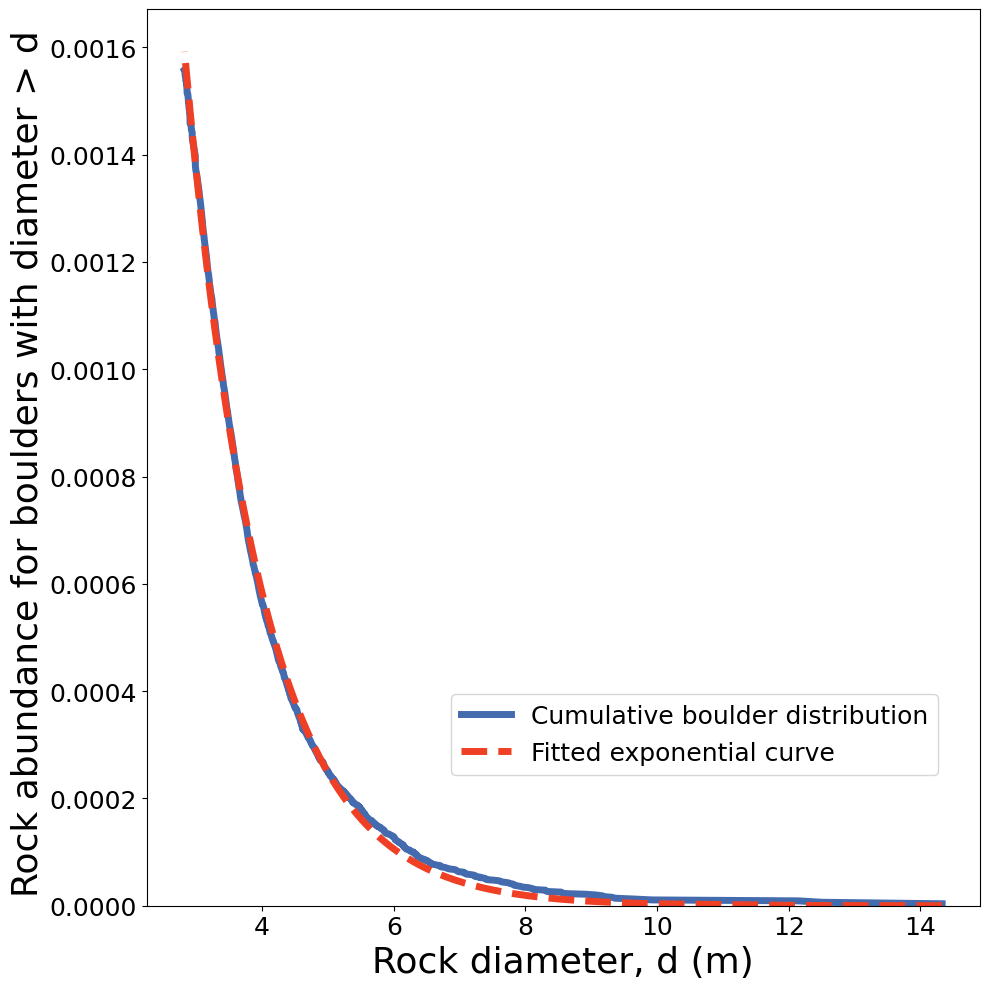

k: 0.01764164604294433
q: 0.8526652089836573
0.007520233216653165


In [67]:
diameterVals, arealFractionVals = get_cumulative_area(bouldersGDFYolo, total_area=total_area, minimum=diameter_threshold)

params, pcov = curve_fit(lambda D,k,q:  rock_abundance_function(D, k, q),  diameterVals,  arealFractionVals,  p0=(0.01, 1))
k = params[0]
q = params[1]


fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(diameterVals, arealFractionVals, 'xkcd:french blue', label="Cumulative boulder distribution", linewidth=5)
ax.plot(diameterVals, rock_abundance_function(diameterVals, k, q), 'xkcd:tomato', linestyle="--", label="Fitted exponential curve", linewidth=5)
ax.set_xlabel("Rock diameter, d (m)", fontsize=26)
ax.set_ylabel("Rock abundance for boulders with diameter > d ", fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=18)
legend = ax.legend(
    prop={'size': 18},
    loc='upper left',
    bbox_to_anchor=(.35, .25)   # (horizontal, vertical)
)
plt.ylim(0)

plt.tight_layout()

plt.show()

print(f'k: {k}')
print(f'q: {q}')
print(rock_abundance_function(1, k, q)) 

In [146]:
y_predicted = rock_abundance_function(diameterVals, k, q)
residuals = arealFractionVals - y_predicted

mse = np.mean(residuals**2)

rmse = np.sqrt(mse)
rmse

1.2182732495039279e-05

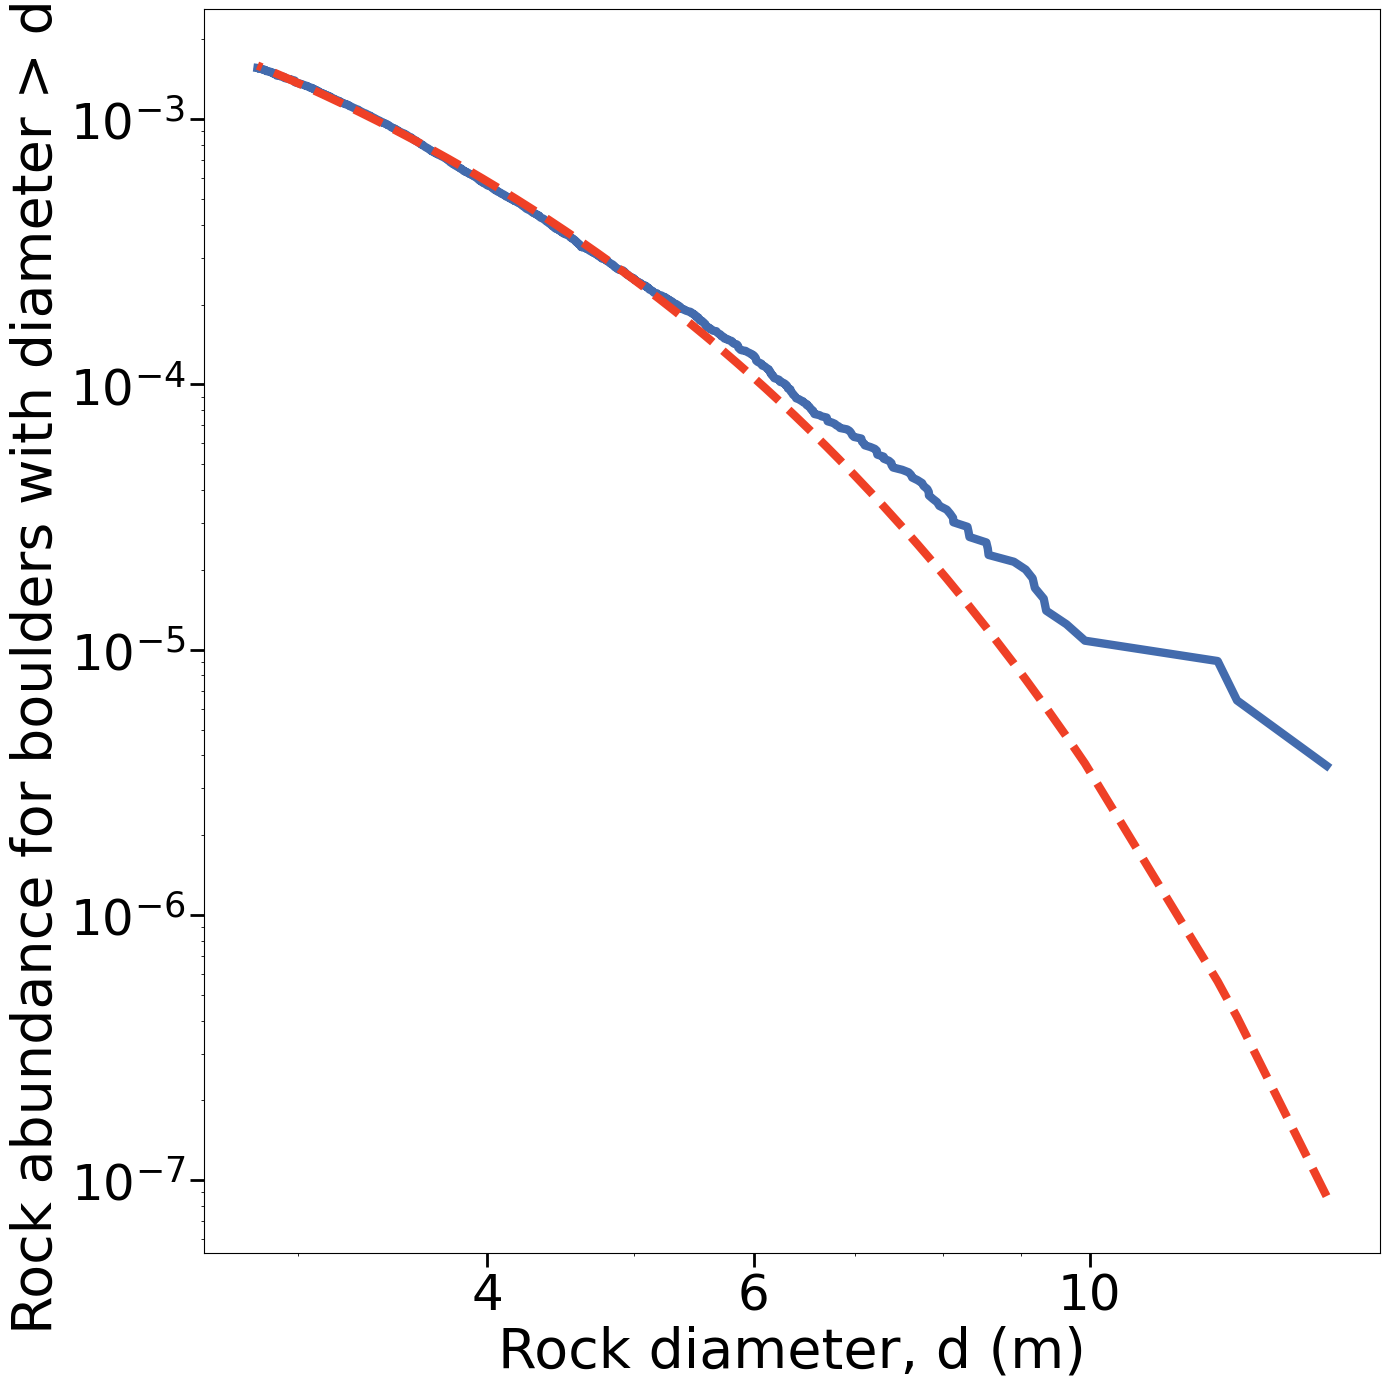

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.plot(diameterVals, arealFractionVals, 'xkcd:french blue', label="Cumulative boulder distribution", linewidth=6)
ax.plot(diameterVals, rock_abundance_function(diameterVals, k, q), 'xkcd:tomato', linestyle="--", label="Fitted exponential curve", linewidth=6)
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel("Rock diameter, d (m)", fontsize=40)
ax.set_ylabel("Rock abundance for boulders with diameter > d    ", fontsize=40)
ax.set_xticks([4, 6, 10], ['4', '6', '10'])
ax.tick_params(axis='both', which='major', labelsize=36, length=10, width = 2)
ax.tick_params(axis='x', which='minor', labelbottom=False)

plt.tight_layout()

# Figure 3 (Smoothing Effect)

In [129]:
boulderNet_map_ra = "Data/YoloBoulderNetRockAbundanceMap.tif" ##UPDATE
diviner_map_ra = "Data/DivinerRockAbundanceMap.tif"

ds = rasterio.open(boulderNet_map_ra)
boulderNetRA = ds.read(1)
ds = rasterio.open(diviner_map_ra)
divinerRA = ds.read(1)
ds = None

Blurring the image

In [130]:
sigmas = [1.69, 0.78]

with rasterio.open(boulderNet_map_ra) as src:
    image_data = src.read(1)  
    blurred_image = gaussian_filter(image_data, sigma = sigmas)

In [131]:
with rasterio.open(
    "Data/BlurredYoloBoulderNetRAMap.tif",
    'w',
    width=src.width,
    height=src.height,
    count=1,  # Number of bands
    dtype=rasterio.float32,
    crs=src.crs, 
    transform=src.transform, 
) as dst:
    dst.write(blurred_image, 1)

CPLE_AppDefinedError: Deleting Data/BlurredYoloBoulderNetRAMap.tif failed: Permission denied

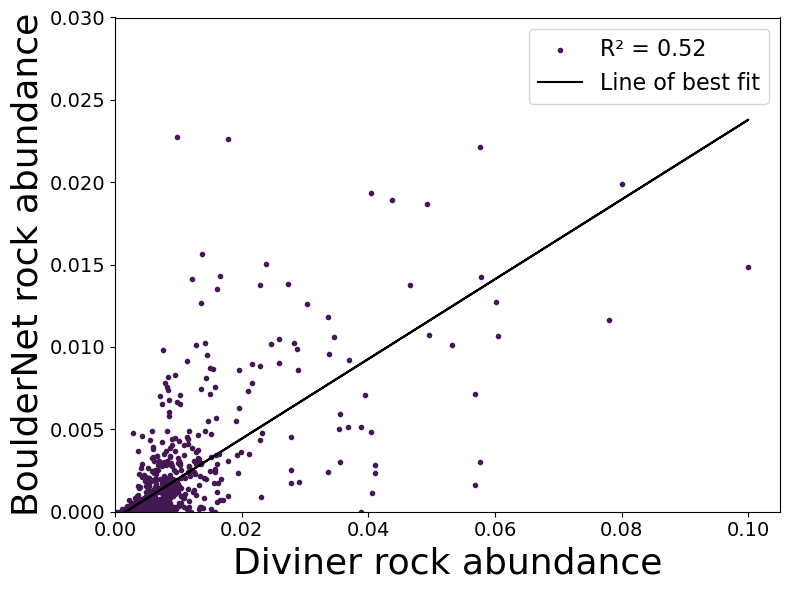

In [ ]:
diviner_ra_vals = divinerRA.flatten()  
boulderNet_ra_vals = boulderNetRA.flatten()

plt.figure(figsize=(8, 6))  


r_squared = (np.corrcoef(diviner_ra_vals, boulderNet_ra_vals)[0][1])**2
plt.scatter(diviner_ra_vals, boulderNet_ra_vals, label=f"R² = {r_squared:.2f}", marker='.', color="#431853")
a, b = np.polyfit(diviner_ra_vals, boulderNet_ra_vals, 1)
plt.plot(diviner_ra_vals, a * diviner_ra_vals + b, color="black", label='Line of best fit')

plt.xlabel("Diviner rock abundance", size=26)
plt.ylabel("BoulderNet rock abundance", size=26)

plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0, ymax=0.03)

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.legend(fontsize=16, loc='upper right')
plt.tight_layout() 
plt.show()

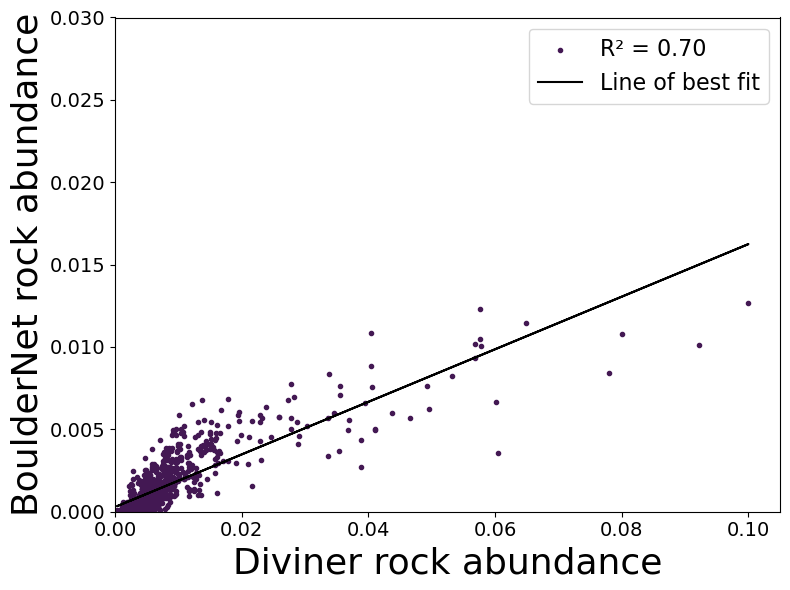

In [ ]:
diviner_ra_vals = divinerRA.flatten() 
blurred_boulderNet_ra_vals = blurredBoulderNetRA.flatten()

plt.figure(figsize=(8, 6)) 

r_squared = (np.corrcoef(diviner_ra_vals, blurred_boulderNet_ra_vals)[0][1])**2
plt.scatter(diviner_ra_vals, blurred_boulderNet_ra_vals, label=f"R² = {r_squared:.2f}", marker='.', color="#431853")
a, b = np.polyfit(diviner_ra_vals, blurred_boulderNet_ra_vals, 1)
plt.plot(diviner_ra_vals, a * diviner_ra_vals + b, color="black", label='Line of best fit')

plt.xlabel("Diviner rock abundance", size=26)
plt.ylabel("BoulderNet rock abundance", size=26)

plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0, ymax=0.03)

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

# Figure 4 (Diviner BoulderNet Comparison)

In [52]:
bouldersGDFYolo = pd.read_csv('Data/yolo_boulders_with_RA_and_tileID.csv')
bouldersGDFYolo['tile_area'] = bouldersGDFYolo['area_2']
bouldersGDFYolo['tile_id'] = bouldersGDFYolo['id_3']
bouldersGDFYolo['boulder_area'] = bouldersGDFYolo['area']
bouldersGDFYolo['diameter'] = 2 *np.sqrt(bouldersGDFYolo['boulder_area'] / np.pi)
bouldersGDFYolo['arealFracYolo'] = bouldersGDFYolo['arealFracY']
bouldersGDFYolo['arealFracPowell'] = bouldersGDFYolo['ArealFrac']
bouldersGDFYolo['DivinerRA'] = bouldersGDFYolo['DivinerRAm']


NUM_TILES = 864
total_area = NUM_TILES * bouldersGDFYolo.tile_area[1] 

area_threshold = .5*.5*5*5
diameter_threshold = 2* (np.sqrt((area_threshold)/ np.pi))

tilesDf = pd.read_csv("Data/TileDfYoloAndPowell.csv").rename(columns={'DivinerRAm': 'DivinerRA', 'id': 'tile_id', 'ArealFrac':'arealFracPowell', 'arealFracY':'arealFracYolo'})

In [53]:
indicies_k = dict()
indicies_q = dict()
indicies_corr_ra = dict()


num_tiles_in_row = 32
num_tiles_in_column = 27


def get_tile_index(x, y):
    return x *num_tiles_in_column + y 

divinerRAs = []
yoloboulderNetRAs = []
powellBoulderRAs = [] 
powellthreshyoloboulderNetRAs = []

yolocorrBoulderNetRAs = []


mean_diameters = []
num_boulders = []

tile_area = bouldersGDFYolo.tile_area[0]
center_tile_indices = []

powellQ_vals = []
yoloQ_vals = []

wholeCorrectedRAList = []
tileBasedCorrectedRAList = []


verbose = False # Set to true to have fit for each tile's boulder distribution graphed
if verbose:
    fig, ax = plt.subplots(figsize=(10, 8))
for xIndex in range(1, num_tiles_in_row - 1):
    for yIndex in range(1, num_tiles_in_column -1):
        potentialTileCoords = [(xIndex - 1, yIndex - 1),(xIndex - 0, yIndex - 1),(xIndex + 1, yIndex - 1),
                                (xIndex - 1, yIndex - 0),(xIndex - 0, yIndex - 0),(xIndex + 1, yIndex - 0),
                                (xIndex - 1, yIndex + 1),(xIndex - 0, yIndex + 1),(xIndex + 1, yIndex + 1)]
        
        potentialTileIndicies = [get_tile_index(pos[0], pos[1]) for pos in potentialTileCoords]
        tileData = tilesDf[tilesDf["tile_id"].isin(potentialTileIndicies)]
                
        if (len(tileData) == 0):
            continue
        
        divinerRA = tileData['DivinerRA'].mean()
        powellBoulderRA = tileData['arealFracPowell'].mean()

        yoloBoulderRA = tileData['arealFracYolo'].mean()
        yoloboulderNetRAs.append(yoloBoulderRA)	

        
        yoloBoulders = bouldersGDFYolo[bouldersGDFYolo["tile_id"].isin(potentialTileIndicies)] 
        if (len(yoloBoulders) < 100):
            continue

        divinerRAs.append(divinerRA)

        powellBoulderRAs.append(powellBoulderRA)


        yoloDiameterVals, yoloArealFractionVals = get_cumulative_area(yoloBoulders, total_area=tile_area*9, minimum=diameter_threshold) 

        yoloParams, yoloPcov = curve_fit(lambda D,k,q:  rock_abundance_function(D, k, q),  yoloDiameterVals,  yoloArealFractionVals,  p0=(0.01, 1))
        yoloK = yoloParams[0]
        yoloQ = yoloParams[1]

        yoloQ_vals.append(yoloQ)

        yolocorrect_rock_abundance = rock_abundance_function(1, yoloK, yoloQ)
        yolocorrBoulderNetRAs.append(yolocorrect_rock_abundance)

        powellthreshyoloboulderNetRAs.append(rock_abundance_function(2, yoloK, yoloQ))

        mean_diameters.append(np.mean(yoloDiameterVals))
        num_boulders.append(len(yoloBoulders))

        center_tile_indices.append(potentialTileIndicies[4])


        # For Figure 8
        a = 0.21097571205021437
        b = 1.2770578774549843
        d_threshtile = a + b*yoloQ
        tilebasedyolocorrect_rock_abundance = rock_abundance_function(d_threshtile, yoloK, yoloQ)
        tileBasedCorrectedRAList.append(tilebasedyolocorrect_rock_abundance)

        wholeCorrectedRAList.append(rock_abundance_function(1.3, yoloK, yoloQ))

        
        if verbose:
            ax.plot(yoloDiameterVals, yoloArealFractionVals, 'orange', linewidth=.2)           
        
        # For the data in Figure 6
        for index in potentialTileIndicies:
            if index not in indicies_k:
                indicies_k[index] = []
                indicies_q[index] = []
                indicies_corr_ra[index] = []
                
            indicies_k[index].append(yoloK)
            indicies_q[index].append(yoloQ)
            indicies_corr_ra[index].append(yolocorrect_rock_abundance)
        


if verbose:
    ax.set_xlabel("Rock diameter, d (m)", fontsize=22)
    ax.set_ylabel("Rock abundance for boulders with diameter > d ", fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=14)

    plt.xscale('log')
    plt.yscale('log')
    plt.title("CDFs plotted but only for q > 1")

    plt.tight_layout()
    plt.show()

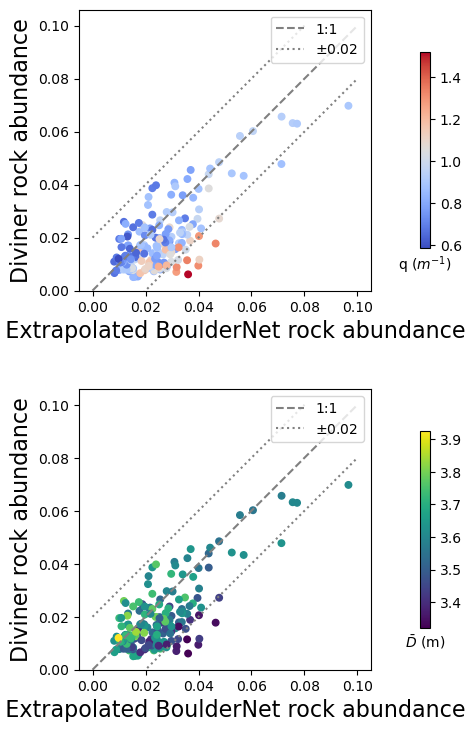

In [54]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Figure 4a
diviner_ra_vals = np.asarray(divinerRAs) 
boulderNet_ra_vals = np.asarray(yolocorrBoulderNetRAs)

ax1.scatter(boulderNet_ra_vals, diviner_ra_vals, marker='o', s=22, c=yoloQ_vals, cmap='coolwarm')
ax1.set_aspect('equal')  

x_vals = np.array([0, 0.1]) 
y_plus_20 = np.array([0, 0.08]) + .02 
y_minus_20 = x_vals - 0.02

ax1.plot(x_vals, x_vals, c='gray', label="1:1", linestyle="--")
ax1.plot(np.array([0, 0.08]), y_plus_20, c='gray', linestyle=':', label="$\pm 0.02$")
ax1.plot(x_vals, y_minus_20, c='gray', linestyle=':')

ax1.set_xlabel("   Extrapolated BoulderNet rock abundance", fontsize=16)
ax1.set_ylabel("Diviner rock abundance", fontsize=16)
ax1.set_ylim(ymin=0.0)
ax1.legend(loc='upper right')
cbar1 = plt.colorbar(ax1.collections[0], ax=ax1, pad=0.08, shrink=0.7)
cbar1.ax.set_xlabel('q $(m^{-1})$')

# Figure 4b
ax2.scatter(boulderNet_ra_vals, diviner_ra_vals, marker='o', s=22, c=mean_diameters, cmap='viridis')
ax2.set_aspect('equal') 

ax2.plot(x_vals, x_vals, c='gray', label="1:1", linestyle="--")
ax2.plot(np.array([0, 0.08]), y_plus_20, c='gray', linestyle=':', label="$\pm 0.02$")
ax2.plot(x_vals, y_minus_20, c='gray', linestyle=':')

ax2.set_xlabel("   Extrapolated BoulderNet rock abundance", fontsize=16)
ax2.set_ylabel("Diviner rock abundance", fontsize=16)
ax2.set_ylim(ymin=0.0)
ax2.legend(loc='upper right')
cbar2 = plt.colorbar(ax2.collections[0], ax=ax2, pad=0.08, shrink=0.7)
cbar2.ax.set_xlabel(r'$\bar{D}$ (m)')

plt.subplots_adjust(hspace=0.35, top=0.6, bottom=0.05)  
plt.show()

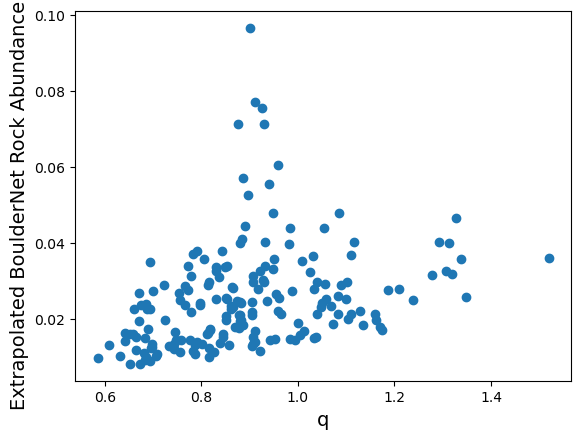

In [61]:
plt.plot(yoloQ_vals, yolocorrBoulderNetRAs, 'o')
plt.xlabel("q", size=14)
plt.ylabel("Extrapolated BoulderNet Rock Abundance   ", size=14)
plt.show()

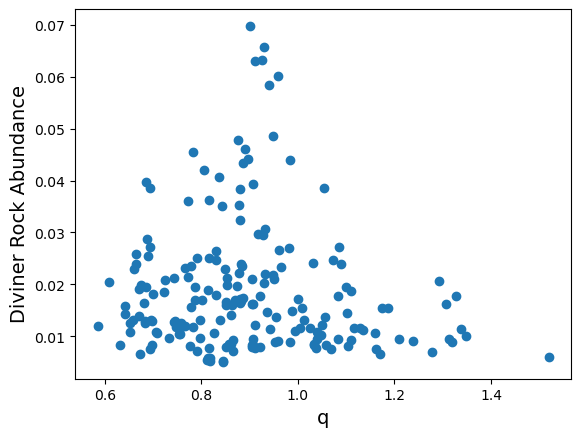

In [63]:
plt.plot(yoloQ_vals, divinerRAs, 'o')
plt.xlabel("q", size=14)
plt.ylabel("Diviner Rock Abundance   ", size=14)
plt.show()

In [27]:
import numpy as np
from sklearn.metrics import r2_score

diviner_ra_vals = np.asarray(divinerRAs)
boulderNet_ra_vals = np.asarray(yolocorrBoulderNetRAs)

# R²
r2 = r2_score(diviner_ra_vals, boulderNet_ra_vals)

# Errors
mean_error = np.mean(diviner_ra_vals - boulderNet_ra_vals)
mae = np.mean(np.abs(diviner_ra_vals - boulderNet_ra_vals))
rmse = np.sqrt(np.mean((diviner_ra_vals - boulderNet_ra_vals)**2))


# Rounded outputs
print("R²:", round(r2, 3))
print("Mean Error:", round(mean_error, 4))
print("MAE:", round(mae, 4))
print("RMSE:", round(rmse, 4))

R²: 0.222
Mean Error: -0.0065
MAE: 0.009
RMSE: 0.0112


# Figure S5

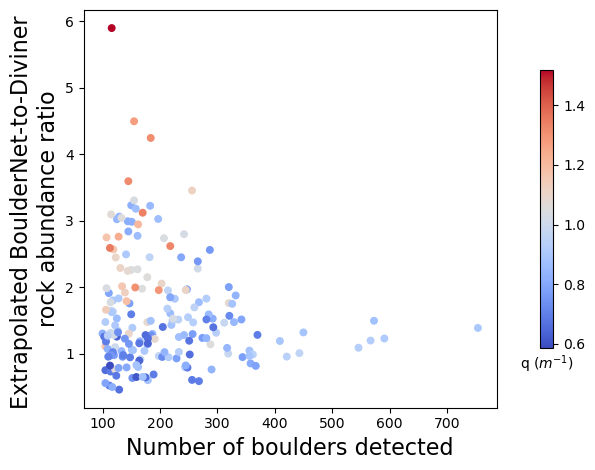

In [46]:
ratios = boulderNet_ra_vals/diviner_ra_vals 

scatter = plt.scatter(num_boulders, ratios, marker='o', s=22, c=yoloQ_vals, cmap='coolwarm')
colorbar = plt.colorbar(scatter, pad=0.08, shrink=0.7)
colorbar.ax.set_xlabel('q $(m^{-1})$') 
plt.xlabel("Number of boulders detected", fontsize=16)
plt.ylabel("Extrapolated BoulderNet-to-Diviner \nrock abundance ratio", fontsize=16)
plt.tight_layout()
plt.show()


# Figure 5 (Powell Comparison)

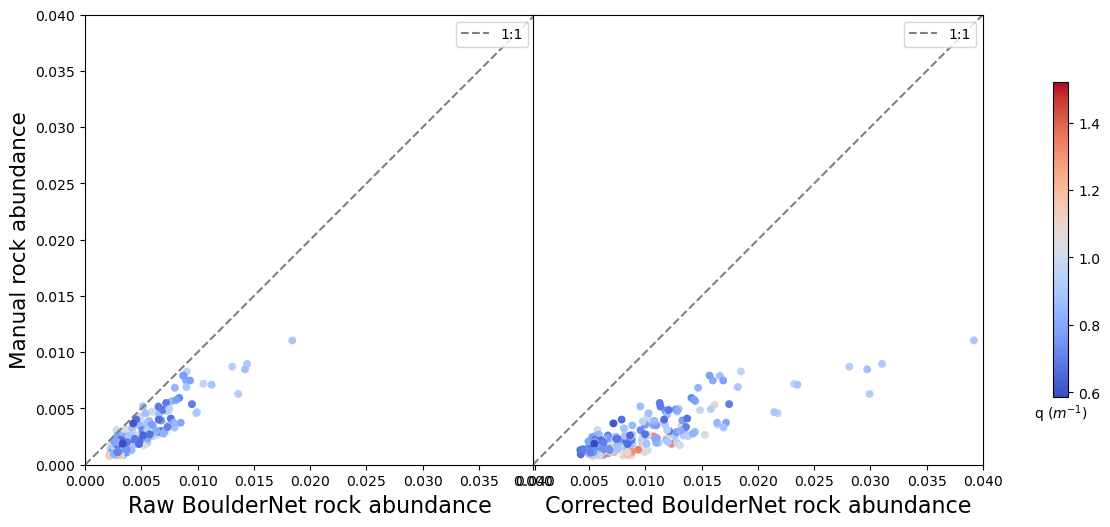

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Setup side-by-side plots (1 row, 2 columns)
# We can use sharey=True to force them to share the Y axis scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

raw_boulderNet_ra_vals = np.array(yoloboulderNetRAs)
powell_thresh_boulderNet_ra_vals = np.asarray(powellthreshyoloboulderNetRAs)
powellBoulder_ra_vals = np.asarray(powellBoulderRAs)

# --- Left Plot ---
ax1.scatter(raw_boulderNet_ra_vals, powellBoulder_ra_vals, marker='o', s=22, c=yoloQ_vals, cmap='coolwarm')
ax1.set_aspect('equal') 

# 1:1 line and guidelines
x_vals = np.array([0, 0.04]) 
ax1.plot(x_vals, x_vals, c='gray', label="1:1", linestyle="--")

ax1.set_xlabel("Raw BoulderNet rock abundance", fontsize=16)
ax1.set_ylabel("Manual rock abundance", fontsize=15.5)
ax1.set_ylim(ymin=0.0, ymax=0.04)
ax1.set_xlim(xmin=0.0, xmax=0.04)
ax1.legend(loc='upper right')

# --- Right Plot ---
sc2 = ax2.scatter(powell_thresh_boulderNet_ra_vals, powellBoulder_ra_vals, marker='o', s=22, c=yoloQ_vals, cmap='coolwarm')
ax2.set_aspect('equal') 

ax2.plot(x_vals, x_vals, c='gray', label="1:1", linestyle="--")

ax2.set_xlabel("Corrected BoulderNet rock abundance", fontsize=16)


ax2.tick_params(left=False, labelleft=False) 

ax2.set_xlim(xmin=0.0, xmax=0.04)
ax2.set_ylim(ymin=0.0, ymax=0.04)
ax2.legend(loc='upper right')

# Colorbar for q (Right side only)
cbar2 = plt.colorbar(sc2, ax=ax2, pad=0.08, shrink=0.7)
cbar2.ax.set_xlabel('q $(m^{-1})$')

plt.tight_layout()
plt.subplots_adjust(wspace=-.5, top=0.9, bottom=0.15)
plt.show()

# Figure 7 (Diviner Threshold Analysis)

In [133]:
bouldersGDFYolo = pd.read_csv('Data/yolo_boulders_with_RA_and_tileID.csv')
bouldersGDFYolo['tile_area'] = bouldersGDFYolo['area_2']
bouldersGDFYolo['tile_id'] = bouldersGDFYolo['id_3']
bouldersGDFYolo['boulder_area'] = bouldersGDFYolo['area']
bouldersGDFYolo['diameter'] = 2 *np.sqrt(bouldersGDFYolo['boulder_area'] / np.pi)
bouldersGDFYolo['arealFracYolo'] = bouldersGDFYolo['arealFracY']
bouldersGDFYolo['arealFracPowell'] = bouldersGDFYolo['ArealFrac']
bouldersGDFYolo['DivinerRA'] = bouldersGDFYolo['DivinerRAm']


NUM_TILES = 864
total_area = NUM_TILES * bouldersGDFYolo.tile_area[1] 

area_threshold = .5*.5*5*5
diameter_threshold = 2* (np.sqrt((area_threshold)/ np.pi))

tilesDf = pd.read_csv("Data/TileDfYoloAndPowell.csv").rename(columns={'DivinerRAm': 'DivinerRA', 'id': 'tile_id', 'ArealFrac':'arealFracPowell', 'arealFracY':'arealFracYolo'})

In [ ]:
num_tiles_in_row = 32
num_tiles_in_column = 27


def get_tile_index(x, y):
    return x *num_tiles_in_column + y 

divinerRAs = []
boulderNetRAs = []
corrBoulderNetRAs = []
k_vals = []
q_vals = []
mean_diameters = []
num_boulders = []
tile_area = bouldersGDFYolo.tile_area[0]

evalThreshDict = {}

evalThreshes = np.arange(0, 2.8 + 0.05, 0.05)

for evalThresh in evalThreshes:
    evalThreshDict[evalThresh] = []

for xIndex in range(1, num_tiles_in_row - 1):
    for yIndex in range(1, num_tiles_in_column -1):
        potentialTileCoords = [(xIndex - 1, yIndex - 1),(xIndex - 0, yIndex - 1),(xIndex + 1, yIndex - 1),
                                (xIndex - 1, yIndex - 0),(xIndex - 0, yIndex - 0),(xIndex + 1, yIndex - 0),
                                (xIndex - 1, yIndex + 1),(xIndex - 0, yIndex + 1),(xIndex + 1, yIndex + 1)]
        
        potentialTileIndicies = [get_tile_index(pos[0], pos[1]) for pos in potentialTileCoords]
        
        actualTiles = tilesDf[tilesDf["tile_id"].isin(potentialTileIndicies)]

        if (len(actualTiles) == 0):
            continue
        
        divinerRA = actualTiles['DivinerRA'].mean()
        boulderNetRA = actualTiles['arealFracYolo'].mean()
        
        boulders = bouldersGDFYolo[bouldersGDFYolo["tile_id"].isin(potentialTileIndicies)]
        if (len(boulders) < 100):
            continue

        diameterVals, arealFractionVals = get_cumulative_area(boulders, total_area=tile_area*9, minimum=2) 

        params, pcov = curve_fit(lambda D,k,q:  rock_abundance_function(D, k, q),  diameterVals,  arealFractionVals,  p0=(0.01, 1))
        k = params[0]
        q = params[1]
        
        k_vals.append(k)
        q_vals.append(q)

        divinerRAs.append(divinerRA)
        boulderNetRAs.append(boulderNetRA)  
    
        mean_diameters.append(np.mean(boulders['diameter']))

        num_boulders.append(len(boulders))

        
        for evalThresh in evalThreshDict:
            evalThreshDict[evalThresh].append(rock_abundance_function(evalThresh, k, q))


In [135]:
thresholds = sorted(evalThreshDict.keys(),reverse=True)
correctThresholds = []
for i in range(len(divinerRAs)):
    errors = []
    for evalThresh in thresholds:
        uncorrRockAbundance = evalThreshDict[evalThresh][i]
        errors.append(np.abs(divinerRAs[i] - uncorrRockAbundance))
    threshold = thresholds[np.argmin(errors)]
    correctThresholds.append(threshold)

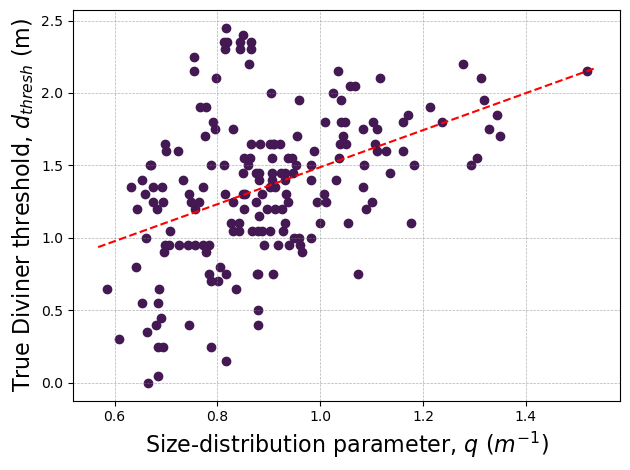

In [ ]:
def model_func(x,a, b):
    return a+b*x

params, covariance = curve_fit(lambda x,a,b:  model_func(x, a, b), q_vals, correctThresholds, p0=(1, 1))

a, b = params

x_fit = np.linspace(min(q_vals)*0.97, max(q_vals)*1.01, 100)
y_fit = model_func(x_fit, a, b)

plt.scatter(q_vals, correctThresholds, color = "#834F95") 
plt.plot(x_fit, y_fit, color='red', linestyle='--')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.xlabel("Size-distribution parameter, $q\ (m^{-1})$", size = 16)
plt.ylabel("True Diviner threshold, $d_{thresh}$ (m)", size = 16)
plt.tight_layout()
plt.show()

In [ ]:
y_predicted = model_func(np.array(q_vals), a, b)
residuals = correctThresholds - y_predicted

mse = np.mean(residuals**2)

rmse = np.sqrt(mse)
rmse

0.4631282713718999

In [138]:
a

0.21097571205021437

In [137]:
b

1.2770578774549843

## Figure 8

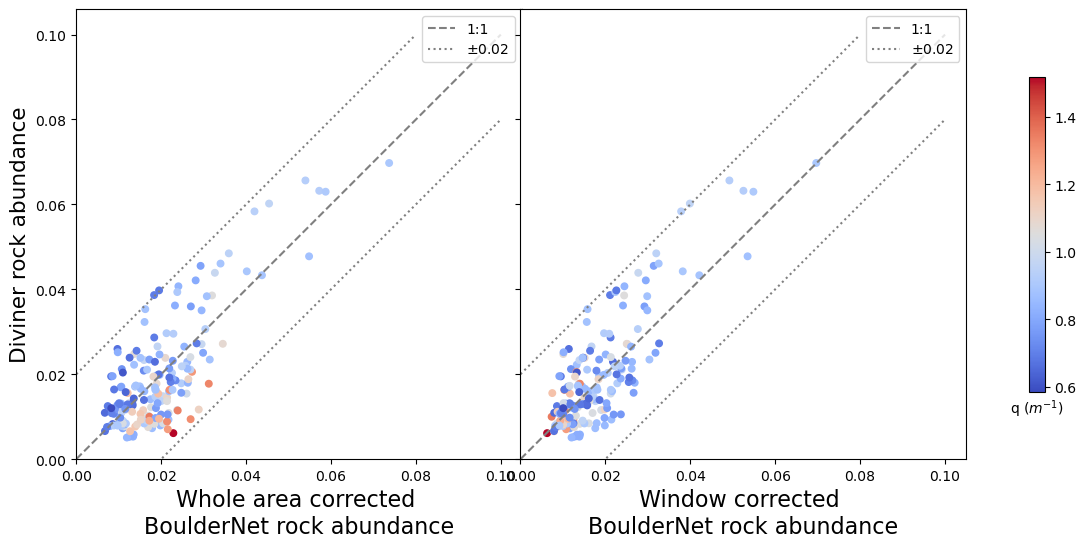

In [36]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- Left Plot ---
ax1.scatter(np.asarray(wholeCorrectedRAList), diviner_ra_vals, marker='o', s=22, c=yoloQ_vals, cmap='coolwarm')
ax1.set_aspect('equal') 

x_vals = np.array([0, 0.1]) 
y_plus_20 = np.array([0, 0.08]) + .02 
y_minus_20 = x_vals - 0.02

ax1.plot(x_vals, x_vals, c='gray', label="1:1", linestyle="--")
ax1.plot(np.array([0, 0.08]), y_plus_20, c='gray', linestyle=':', label="$\pm 0.02$")
ax1.plot(x_vals, y_minus_20, c='gray', linestyle=':')

ax1.set_xlabel("Whole area corrected \nBoulderNet rock abundance", fontsize=16)
ax1.set_ylabel("Diviner rock abundance", fontsize=15.5)
ax1.set_ylim(ymin=0.0)
ax1.set_xlim(xmin=0.0)
ax1.legend(loc='upper right')

# --- Right Plot ---
sc2 = ax2.scatter(np.asarray(tileBasedCorrectedRAList), diviner_ra_vals, marker='o', s=22, c=yoloQ_vals, cmap='coolwarm')
ax2.set_aspect('equal') 

ax2.plot(x_vals, x_vals, c='gray', label="1:1", linestyle="--")
ax2.plot(np.array([0, 0.08]), y_plus_20, c='gray', linestyle=':', label="$\pm 0.02$")
ax2.plot(x_vals, y_minus_20, c='gray', linestyle=':')

ax2.set_xlabel("Window corrected \nBoulderNet rock abundance", fontsize=16)

ax2.set_xlim(xmin=0.0)
ax2.set_ylim(ymin=0.0)
ax2.legend(loc='upper right')

# Colorbar for q (Right side only)
cbar2 = plt.colorbar(sc2, ax=ax2, pad=0.08, shrink=0.7)
cbar2.ax.set_xlabel('q $(m^{-1})$')

plt.subplots_adjust(wspace=-.42, top=0.9, bottom=0.15)
plt.show()

# Figure 6 (Spatial Parameter Distribution Analysis)

In [ ]:
# Data used to create the grid in QGIS

# Requires the code for figure 4 to be ran first

indicies_q_copy = dict()

for index in sorted(indicies_q):
    indicies_q_copy[index] = np.round(np.mean(indicies_q[index]), 4)


indicies_k_copy = dict()

for index in sorted(indicies_k):
    indicies_k_copy[index] = np.round(np.mean(indicies_k[index]), 4)


indicies_corr_ra_copy = dict()

for index in sorted(indicies_corr_ra):
    indicies_corr_ra_copy[index] = np.round(np.mean(indicies_corr_ra[index]), 4)


newcolsdf = pd.DataFrame({
    "yoloQ": pd.Series(indicies_q_copy),
    "yoloK": pd.Series(indicies_k_copy),
    "yoloCorrRA": pd.Series(indicies_corr_ra_copy)
})

# Move index → column named "id"
newcolsdf = newcolsdf.reset_index().rename(columns={"index": "id"})

{21: 0.8172, 22: 0.818, 23: 0.8266, 24: 0.8313, 25: 0.8438, 36: 0.7917, 37: 0.8209, 38: 0.8356, 39: 0.8575, 40: 0.8649, 48: 0.8149, 49: 0.8157, 50: 0.8251, 51: 0.8303, 52: 0.8441, 63: 0.9128, 64: 0.8854, 65: 0.878, 66: 0.8606, 67: 0.8633, 75: 0.8149, 76: 0.8157, 77: 0.8251, 78: 0.8303, 79: 0.8441, 89: 1.0677, 90: 0.9876, 91: 0.9386, 92: 0.9036, 93: 0.8693, 94: 0.8633, 102: 0.8125, 103: 0.8133, 104: 0.8237, 105: 0.8293, 106: 0.8445, 116: 1.0677, 117: 1.0529, 118: 0.9857, 119: 0.9445, 120: 0.8771, 121: 0.8617, 143: 1.0677, 144: 1.0624, 145: 1.0096, 146: 0.9805, 147: 0.9039, 245: 1.5196, 246: 1.3991, 247: 1.323, 248: 1.2247, 249: 1.171, 258: 1.0375, 259: 1.0375, 260: 1.0375, 272: 1.4192, 273: 1.3574, 274: 1.2936, 275: 1.2308, 276: 1.1661, 284: 1.0401, 285: 1.039, 286: 1.0413, 287: 1.0417, 288: 1.0481, 298: 1.0834, 299: 1.2365, 300: 1.2361, 301: 1.2066, 302: 1.1661, 303: 1.0966, 311: 1.0449, 312: 1.0351, 313: 1.0302, 314: 1.0209, 315: 1.0133, 316: 1.004, 325: 1.0385, 326: 1.0662, 327: 1.11

In [ ]:
import geopandas as gpd

# Load rock abundance grid shapefile
gdf = gpd.read_file("../rock_abundance_with_Powell_and_yolo.shp")\

merged = gdf.merge(newcolsdf, on="id", how="left")

merged.to_file("../rock_abundance_with_Powell_and_yolo_with_params.shp")


Colorbars for Figure 6

In [ ]:
import matplotlib.cm as cm

## Uncomment whichever pair needed to get the colorbar for Figure 6 a, b, or c, respectively

data = merged.yoloQ
colormap = cm.get_cmap('coolwarm')

# data = merged.yoloK
# colormap = cm.get_cmap('Purples')

# data = merged.yoloCorrRA
# colormap = cm.get_cmap('Oranges')


scalar_mappable = cm.ScalarMappable(cmap=colormap)
scalar_mappable.set_array(data)

NameError: name 'merged' is not defined

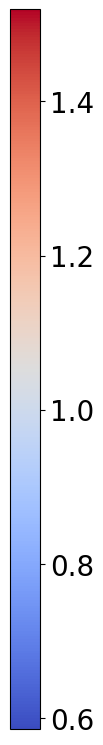

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))

fig.subplots_adjust(bottom=0.05, top=0.95, left=0.5, right=0.55)

cbar = plt.colorbar(
    scalar_mappable,
    cax=ax,
    orientation='vertical'
)

cbar.ax.tick_params(labelsize=20) 

plt.show()

## Supplemental Figure 2 (Model SRF)

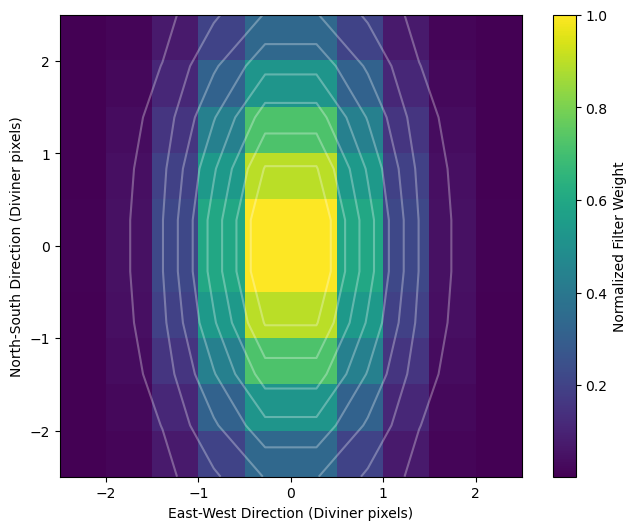

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_gaussian_kernel(sigma_x=0.78, sigma_y=1.69, kernel_size=10):
    ax = np.linspace(-(kernel_size//2), kernel_size//2, kernel_size) * 0.5  # Convert to Diviner pixels
    xx, yy = np.meshgrid(ax, ax)
    
    kernel = np.exp(-(xx**2 / (2 * sigma_x**2) + yy**2 / (2 * sigma_y**2)))
    kernel = kernel / (2 * np.pi * sigma_x * sigma_y)
    
    kernel = kernel / kernel.max()
    
    return kernel, xx, yy

kernel, xx, yy = create_gaussian_kernel()

# 2D Heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(kernel, cmap='viridis', extent=[xx.min(), xx.max(), yy.min(), yy.max()])
plt.xlabel('East-West Direction (Diviner pixels)')
plt.ylabel('North-South Direction (Diviner pixels)')
plt.colorbar(label='Normalized Filter Weight')

# Add contour lines to the heatmap
levels = np.linspace(0, 1, 10)
plt.contour(xx, yy, kernel, levels=levels, colors='white', alpha=0.3)
plt.show()

